In [1]:
library(dplyr)
library(jsonlite)
library(ggplot2)
library(raster)
library(tidyr)
options(warn=-1)



Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: sp

Attaching package: ‘raster’

The following object is masked from ‘package:dplyr’:

    select


Attaching package: ‘tidyr’

The following object is masked from ‘package:raster’:

    extract



# R SDM Processing Pipeline

Here we present the pipeline for acquiring and processing occurrence and climate data for the purposes of species distribution modeling. We presume single species GBIF point observations and raster climate data of varying timescales. Past work has included BIOCLIM and other aggregate climatological metrics.

## 1. Process Occurrence Data

To bypass the challenges of programmatiically downloading large quantities of GBIF data, we've extracted the data manually using GBIF's [occurrence search portal](http://www.gbif.org/species) to download all available occurences within a specified geographic bounding box, which was acquired [here](boundingbox.klokantech.com). 

We first load parameters for this experiment, then load the necessary occurrence files. 

In [2]:
parameters = fromJSON('../parameters.json')
parameters

$species
[1] "sceloporus occidentalis"

$occdata
[1] "/Users/tony/Dropbox/Projects/UW/physdm/data/occs/sceloporus_occidentalis_westus.csv"

$bbox
[1] -124.49733   31.01667 -105.00700   48.33540

$time_periods
[1] "1900:1939" "1970:2009"

$bioclim_dir
[1] "/Users/tony/Dropbox/Projects/UW/physdm/data/climate/"

In [3]:
occurrences = read.csv(parameters$occdata, sep='\t')
head(occurrences)

gbifid     datasetkey                          
1 1562985257 50c9509d-22c7-4a22-a47d-8c48425ef4a7
2 1562985245 50c9509d-22c7-4a22-a47d-8c48425ef4a7
3 1562985190 50c9509d-22c7-4a22-a47d-8c48425ef4a7
4 1562985170 50c9509d-22c7-4a22-a47d-8c48425ef4a7
5 1562985061 50c9509d-22c7-4a22-a47d-8c48425ef4a7
6 1562985049 50c9509d-22c7-4a22-a47d-8c48425ef4a7
  occurrenceid                                   kingdom  phylum   class   
1 http://www.inaturalist.org/observations/894194 Animalia Chordata Reptilia
2 http://www.inaturalist.org/observations/886454 Animalia Chordata Reptilia
3 http://www.inaturalist.org/observations/851281 Animalia Chordata Reptilia
4 http://www.inaturalist.org/observations/839234 Animalia Chordata Reptilia
5 http://www.inaturalist.org/observations/775932 Animalia Chordata Reptilia
6 http://www.inaturalist.org/observations/771173 Animalia Chordata Reptilia
  order    family          genus      species                 ⋯ recordnumber
1 Squamata Phrynosomatidae Sceloporus Sceloporus occidentalis ⋯             
2 Squamata Phrynosomatidae Sceloporus Sceloporus occidentalis ⋯             
3 Squamata Phrynosomatidae Sceloporus Sceloporus occidentalis ⋯             
4 Squamata Phrynosomatidae Sceloporus Sceloporus occidentalis ⋯             
5 Squamata Phrynosomatidae Sceloporus Sceloporus occidentalis ⋯             
6 Squamata Phrynosomatidae Sceloporus Sceloporus occidentalis ⋯             
  identifiedby license      rightsholder recordedby   typestatus
1              CC_BY_NC_4_0 James Maughn James Maughn           
2              CC_BY_NC_4_0 James Maughn James Maughn           
3              CC_BY_NC_4_0 James Maughn James Maughn           
4              CC_BY_NC_4_0 James Maughn James Maughn           
5              CC_BY_NC_4_0 James Maughn James Maughn           
6              CC_BY_NC_4_0 James Maughn James Maughn           
  establishmentmeans lastinterpreted   mediatype
1                    2017-05-29T15:20Z          
2                    2017-05-29T15:20Z          
3                    2017-05-29T15:20Z          
4                    2017-05-29T15:20Z          
5                    2017-05-29T15:20Z          
6                    2017-05-29T15:20Z          
  issue                                          
1 GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
2 GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
3 GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
4 GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
5 GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED
6 GEODETIC_DATUM_ASSUMED_WGS84;COORDINATE_ROUNDED

In [4]:
colnames(occurrences)

[1] "gbifid"                        "datasetkey"                   
 [3] "occurrenceid"                  "kingdom"                      
 [5] "phylum"                        "class"                        
 [7] "order"                         "family"                       
 [9] "genus"                         "species"                      
[11] "infraspecificepithet"          "taxonrank"                    
[13] "scientificname"                "countrycode"                  
[15] "locality"                      "publishingorgkey"             
[17] "decimallatitude"               "decimallongitude"             
[19] "coordinateuncertaintyinmeters" "coordinateprecision"          
[21] "elevation"                     "elevationaccuracy"            
[23] "depth"                         "depthaccuracy"                
[25] "eventdate"                     "day"                          
[27] "month"                         "year"                         
[29] "taxonkey"                      "specieskey"                   
[31] "basisofrecord"                 "institutioncode"              
[33] "collectioncode"                "catalognumber"                
[35] "recordnumber"                  "identifiedby"                 
[37] "license"                       "rightsholder"                 
[39] "recordedby"                    "typestatus"                   
[41] "establishmentmeans"            "lastinterpreted"              
[43] "mediatype"                     "issue"

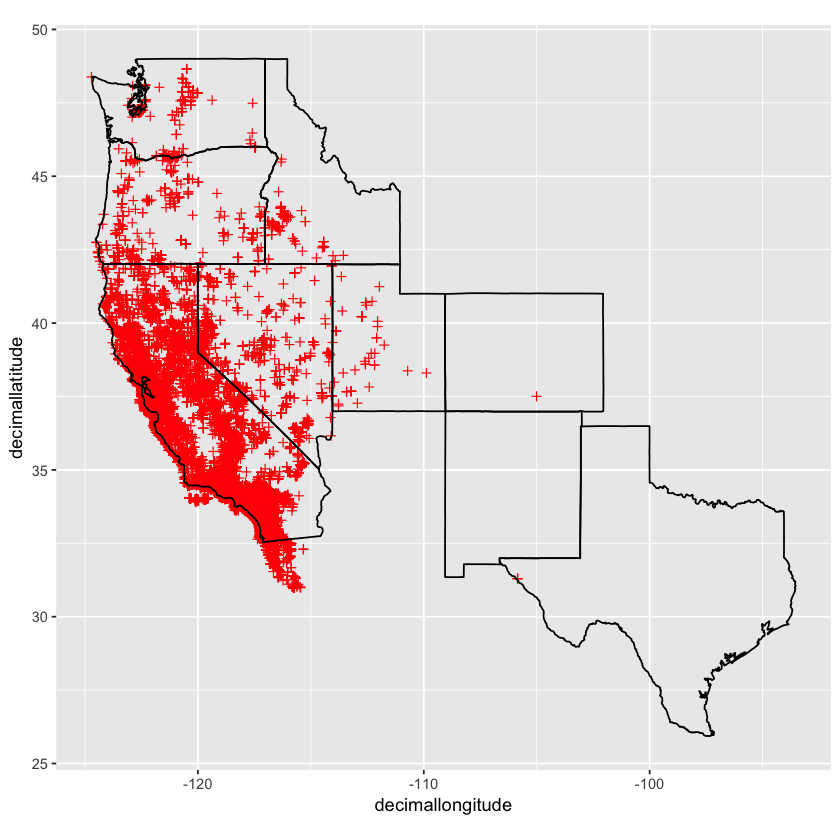

In [5]:
states = map_data('state')
west = subset(states, region %in% c("california", "oregon", "washington", 'idaho', 'utah', 'colorado', 'texas', 'nevada', 'new mexico'))

ggplot() +
geom_point(data=occurrences, aes(x=decimallongitude, y=decimallatitude), shape=3, color='red') +
geom_polygon(data=west , aes(x = long, y = lat, group=group), fill=NA, color='black') +
coord_fixed(1.3) + 
guides(fill=FALSE)

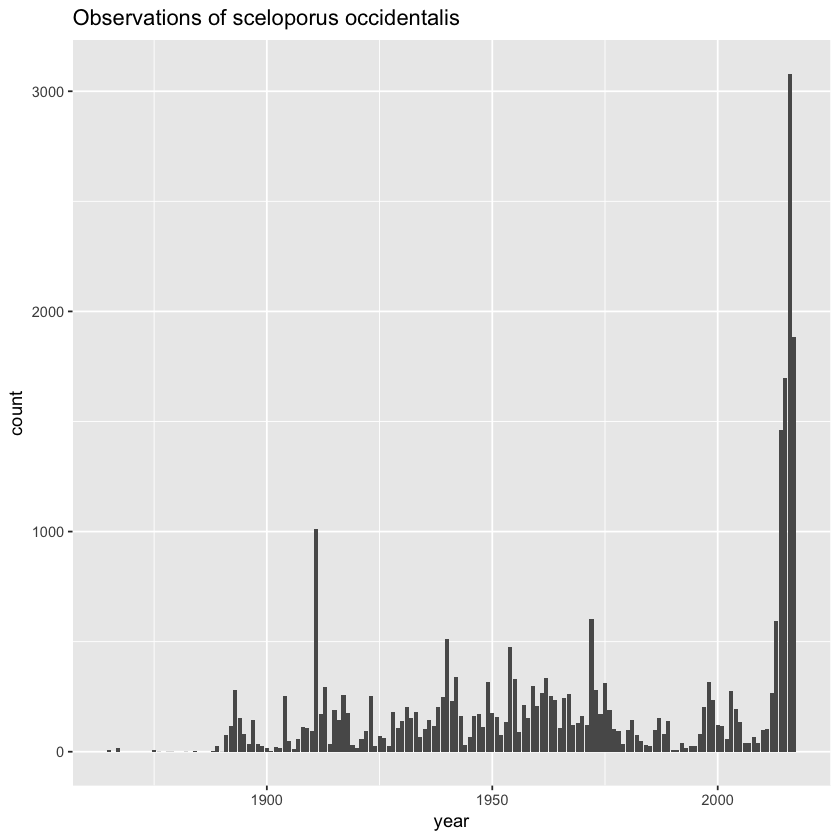

In [6]:
ggplot(occurrences, aes(year)) + geom_bar() + ggtitle(paste0("Observations of ", parameters$species))

The purpose of this particular experiment is to compare SDM performance across time, which means we need to subset the data. The time periods are in the parameters file: 

In [7]:
period_occs = list()

print(parameters$time_periods)
for (period_idx in seq_along(parameters$time_periods)){
    split = strsplit(parameters$time_periods[period_idx], ":")
    start = as.integer(split[[1]][1])
    end = as.integer(split[[1]][2])
    oc = occurrences %>% filter(year >= start & year <= end)
    period_occs[[period_idx]] = oc
}

[1] "1900:1939" "1970:2009"


In [8]:
period_occs[[1]] %>% summarise(period = parameters$time_periods[[1]], minyear = min(year), maxyear = max(year))

period    minyear maxyear
1 1900:1939 1900    1939

In [9]:
period_occs[[2]] %>% summarise(period = parameters$time_periods[[2]], minyear = min(year), maxyear = max(year))

period    minyear maxyear
1 1970:2009 1970    2009

## 2. Download Corresponding Climate Data
Unforunately, for most of the climate data providers, there's not an easy way to get climate information through a web interface. As a result, we're going to rely on the `prism` R package to programmattically download the climate information we need. There are lots of ways to tackle this part of the process, and we're building some tools for that in the future. We're going to save all of the prism data in the default directory, which is `~/prismtmp`. We're also going to keep the `zip` files in case we need to get at the data again.  

In [10]:
library(prism)

To most effectively use the PRISM library, we need to know the years for which we need climate information. For this particular experiment we're comparing model performance across time. This means we have two chunks of climate data that are needed:

In [11]:
parameters$time_periods

[1] "1900:1939" "1970:2009"

In [12]:
period_clim = list()

for (period_idx in seq_along(parameters$time_periods)){
    split = strsplit(parameters$time_periods[period_idx], ":")
    start = as.integer(split[[1]][1])
    end = as.integer(split[[1]][2])
    tmin = prism::get_prism_monthlys('tmin', years=start:end, mon=1:12, keepZip=T)
    period_clim[[period_idx]] = tmin
}

You have not set a path to hold your prism files.


Noticing above, this code only downloads the `tmin` variable (min temperature) monthly for the time periods in the parameters file. This produces a bunch of files:

In [13]:
nrow(ls_prism_data())

You have not set a path to hold your prism files.


Please enter the full or relative path to download files to (hit enter to use default '~/prismtmp'): 


[1] 948

We can take a look at one of them: `

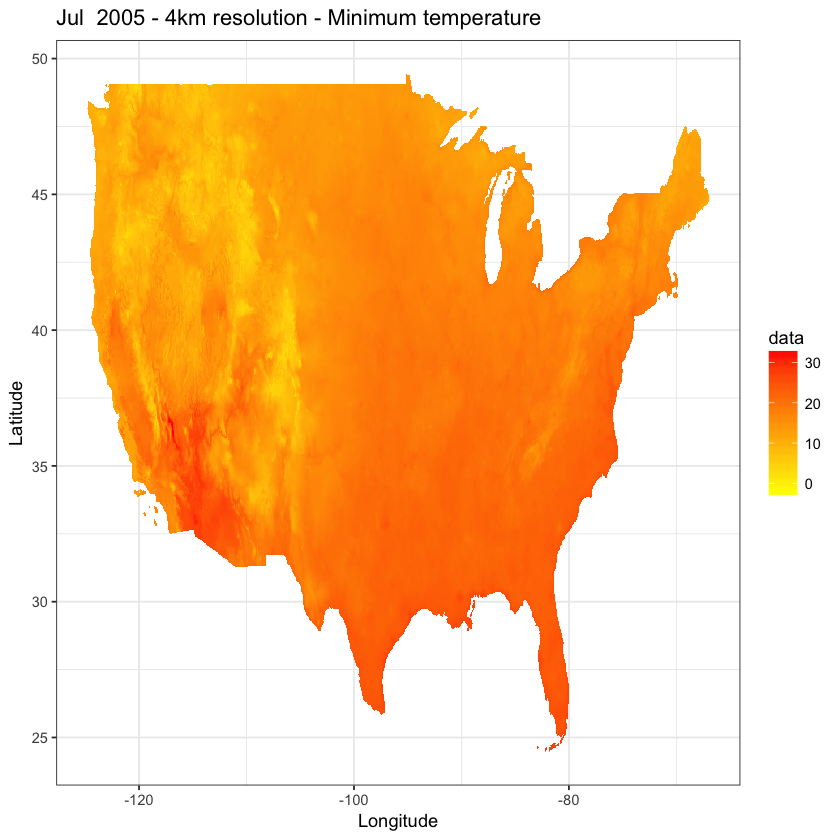

In [14]:
prism_image(ls_prism_data()[895,1], col='heat')

The process is identical for `tmax` and `pcp`.

## 3. Extracting Climate Data for Each Occurrence
This portion of the pipeline is easily the most frustrating, and can be computationally intractible for large quantities of data. The hope here is to scale this system to a large number of occurences and to pull from a high-quality multivariate environmental dataset without much trouble, but that requires a significant investment in infrastructure. For now, we'll try to engineer this in a way which is in-memory computable. 

Because PRISM files are monthly, we have to subset the occurence information by month, then extract the data that way. Here goes: 

In [109]:
extractPRISMvar <- function(lons, lats, month, year, variable){
    searchstr = sprintf("PRISM_%s_stable_4kmM2_%d%02d", variable, year, month)
    result = (ls_prism_data(absPath = T)[grep(searchstr, ls_prism_data()[,1]),]$abs_path)
    if (length(result) != 1) {
        print("No Results or something is buggy!")
        return(data.frame())
    }
    rast = raster(result)
    points = SpatialPoints(data.frame(lons, lats))
    print(points)
    return(data.frame(raster::extract(rast, points, lons, lats)))
}

In [110]:
groups = period_occs[[1]] %>%
filter(!is.na(year)) %>% 
filter(!is.na(month)) %>%
group_by(year, month)


ans = groups %>% do(extractPRISMvar(.$decimallongitude, .$decimallatitude, head(.$month,1), head(.$year,1), 'tmin')) 

class       : SpatialPoints 
features    : 18 
extent      : -119.2416, -119.2416, 34.44984, 34.44984  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
class       : SpatialPoints 
features    : 2 
extent      : -116.5461, -116.5461, 33.06893, 33.06893  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
class       : SpatialPoints 
features    : 1 
extent      : -121.8936, -121.8936, 36.60028, 36.60028  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
class       : SpatialPoints 
features    : 1 
extent      : -119.4597, -119.4597, 37.83086, 37.83086  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
class       : SpatialPoints 
features    : 2 
extent      : -121.5497, -121.4957, 36.23238, 36.23378  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
class       : SpatialPoints 
features    : 5 
extent      : -121.9778, -116.6117, 36.05199, 39.40355  (xmin, xmax, ymin, ymax)
coord. ref. : NA 
class       : SpatialPoints 
features    : 12 
extent      : -120.8557, -120.8113, 39.18067, 39.2065  (xmin, xmax, ymin, ymax)
co

In [112]:
ans

year month structure.9.64999961853027...Names....value..
1   1900  5    9.65                                         
2   1901  4      NA                                         
3   1901  7      NA                                         
4   1901  9      NA                                         
5   1902  7      NA                                         
6   1902  8      NA                                         
7   1902 10      NA                                         
8   1902 11      NA                                         
9   1903  3      NA                                         
10  1903  4      NA                                         
11  1903  5      NA                                         
12  1903  7      NA                                         
13  1903  8      NA                                         
14  1903  9      NA                                         
15  1904  3      NA                                         
16  1904  4      NA                                         
17  1904  5      NA                                         
18  1904  6      NA                                         
19  1904  7    9.65                                         
20  1904  8      NA                                         
21  1904  9      NA                                         
22  1905  4      NA                                         
23  1905  6      NA                                         
24  1905  7      NA                                         
25  1905  8      NA                                         
26  1906  3      NA                                         
27  1906  6      NA                                         
28  1906  8      NA                                         
29  1906  9      NA                                         
30  1906 12      NA                                         
⋮   ⋮    ⋮     ⋮                                            
260 1936 10    NA                                           
261 1937  3    NA                                           
262 1937  4    NA                                           
263 1937  5    NA                                           
264 1937  6    NA                                           
265 1937  7    NA                                           
266 1937  8    NA                                           
267 1937  9    NA                                           
268 1937 10    NA                                           
269 1938  2    NA                                           
270 1938  3    NA                                           
271 1938  4    NA                                           
272 1938  5    NA                                           
273 1938  6    NA                                           
274 1938  7    NA                                           
275 1938  8    NA                                           
276 1938  9    NA                                           
277 1938 10    NA                                           
278 1938 11    NA                                           
279 1939  1    NA                                           
280 1939  2    NA                                           
281 1939  3    NA                                           
282 1939  4    NA                                           
283 1939  5    NA                                           
284 1939  6    NA                                           
285 1939  7    NA                                           
286 1939  8    NA                                           
287 1939  9    NA                                           
288 1939 10    NA                                           
289 1939 11    NA                                           
    structure.9.64999961853027...Names....value...1
1   9.65                                           
2     NA                                           
3     NA                                           
4     NA      

In [108]:
a %>% dplyr::select(decimallatitude, decimallongitude, tmin, month, year)

decimallatitude decimallongitude tmin  month year
1    34.36666        -118.2016         9.65 8     1908
2    34.10986        -118.5706         9.65 7     1915
3    33.83580        -116.9890         9.65 5     1916
4    48.30930        -120.6560         9.65 7     1918
5    43.29990        -116.5300         9.65 8     1922
6    37.22676        -121.6958         9.65 8     1902
7    46.42340        -120.9540         9.65 9     1917
8    45.72760        -121.4860         9.65 8     1918
9    38.01173        -122.7018         9.65 9     1911
10   34.45835        -118.5417         9.65 4     1916
11   37.68445        -121.9218         9.65 7     1905
12   37.83254        -122.4908         9.65 4     1913
13   39.95162        -119.6007         9.65 7     1924
14   34.10986        -118.5706         9.65 7     1915
15   36.63069        -119.0127         9.65 8     1907
16   33.83580        -116.9890         9.65 5     1916
17   34.45835        -118.5417         9.65 4     1916
18   34.18527        -117.7546         9.65 9     1917
19   37.83254        -122.4908         2.32 4     1913
20   33.66830        -117.7890         2.32 8     1911
21   40.98028        -122.1978         8.24 8     1912
22   32.85840        -116.9130        -0.75 5     1916
23   48.33540        -120.6950        11.18 7     1918
24   47.86240        -120.4180        13.52 7     1918
25   45.94140        -120.6540        11.27 3     1939
26   45.72760        -121.4860        11.97 8     1918
27   38.73226        -117.0487         9.53 6     1915
28   35.14023        -119.0747        15.34 7     1904
29   34.18527        -117.7546        11.27 6     1918
30   33.92560        -116.8760         8.20 6     1924
⋮    ⋮               ⋮                ⋮     ⋮     ⋮   
5439 32.85326        -116.6170        11.06 5     1926
5440 32.85326        -116.6170        14.35 5     1926
5441 32.85326        -116.6170        14.35 5     1926
5442 32.82147        -116.5292        11.19 5     1926
5443 32.82147        -116.5292        12.45 5     1926
5444 32.78975        -116.6739         8.85 5     1926
5445 32.85326        -116.6170        13.45 5     1926
5446 33.37045        -117.0747         8.85 6     1926
5447 33.37045        -117.0747         8.85 6     1926
5448 32.82147        -116.5292         8.85 5     1926
5449 32.82147        -116.5292         6.39 5     1926
5450 32.82147        -116.5292         8.85 5     1926
5451 32.82147        -116.5292         8.85 5     1926
5452 32.82147        -116.5292         6.39 5     1926
5453 32.82147        -116.5292         8.85 5     1926
5454 32.82147        -116.5292        11.19 5     1926
5455 32.82147        -116.5292        11.19 5     1926
5456 32.82147        -116.5292        11.18 5     1926
5457 32.82147        -116.5292        10.38 5     1926
5458 32.82147        -116.5292        15.18 5     1926
5459 32.82147        -116.5292         9.58 5     1926
5460 32.64425        -116.7814        11.60 4     1926
5461 32.64425        -116.7814         8.96 4     1926
5462 32.64425        -116.7814         9.85 4     1926
5463 32.64425        -116.7814         9.85 3     1926
5464 32.64425        -116.7814        11.80 3     1926
5465 32.64425        -116.7814        11.80 3     1926
5466 32.67983        -116.8570         9.20 3     1926
5467 32.84181        -116.6953         7.35 3     1926
5468 32.64425        -116.7814         4.25 3     1926

In [103]:
colnames(a)

[1] "gbifid"                        "datasetkey"                   
 [3] "occurrenceid"                  "kingdom"                      
 [5] "phylum"                        "class"                        
 [7] "order"                         "family"                       
 [9] "genus"                         "species"                      
[11] "infraspecificepithet"          "taxonrank"                    
[13] "scientificname"                "countrycode"                  
[15] "locality"                      "publishingorgkey"             
[17] "decimallatitude"               "decimallongitude"             
[19] "coordinateuncertaintyinmeters" "coordinateprecision"          
[21] "elevation"                     "elevationaccuracy"            
[23] "depth"                         "depthaccuracy"                
[25] "eventdate"                     "day"                          
[27] "month"                         "year"                         
[29] "taxonkey"                      "specieskey"                   
[31] "basisofrecord"                 "institutioncode"              
[33] "collectioncode"                "catalognumber"                
[35] "recordnumber"                  "identifiedby"                 
[37] "license"                       "rightsholder"                 
[39] "recordedby"                    "typestatus"                   
[41] "establishmentmeans"            "lastinterpreted"              
[43] "mediatype"                     "issue"                        
[45] "tmin"